<a href="https://colab.research.google.com/github/ChhaviC/comp3132/blob/main/LabWeek13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Week 13 - Visualization & Fine-Tuning


#Trasnfer learning (Review and Practice)

## Reusing pre-trained networks
It is very useful to utilize this pre-trained network for feature detection in any images that might resemble those from benchmark databases such as ImageNet and then train a new fully connected network to classify our costum images using these features.


![](https://dev-to-uploads.s3.amazonaws.com/i/2oyycxxs02jmcghplwc4.png)




## Helper functions

In [1]:
import matplotlib.pyplot as plt
def plot_history(history, color='blue', prefix=""):
    history_dict = history.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    epochs = range(1, len(loss_values) + 1)

    # Make a figure with two subplots side by side
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)

    plt.plot(epochs, loss_values, "o",  color=color, label=prefix + " Training loss")
    plt.plot(epochs, val_loss_values, color=color, label=prefix + " Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(framealpha=0.5)
    plt.grid()

    plt.subplot(1, 2, 2)
    acc_values = history_dict["accuracy"]
    val_acc_values = history_dict["val_accuracy"]
    plt.plot(epochs, acc_values, "o", color=color , label=prefix + " Training accuracy")
    plt.plot(epochs, val_acc_values, color=color, label=prefix + " Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(framealpha=0.5)
    plt.grid()

## Loading the data

We will be using the same cats and dogs dataset from the last week, but downloded in simpler way.

In [2]:
## Download a zip with a subset of the cats and dogs from Gootl Drive
!gdown 1HxDoufgbF11R_xPfFmdXLnfztPXYaKiS

Downloading...
From (original): https://drive.google.com/uc?id=1HxDoufgbF11R_xPfFmdXLnfztPXYaKiS
From (redirected): https://drive.google.com/uc?id=1HxDoufgbF11R_xPfFmdXLnfztPXYaKiS&confirm=t&uuid=5077742e-3621-4c58-8db4-d964c52cc718
To: /content/catsVdogs_small.zip
100% 114M/114M [00:03<00:00, 35.8MB/s]


In [3]:
!unzip -o -q catsVdogs_small.zip

### Data preprocessing (For this section just run the cells)

**Copying images to training, validation, and test directories**

In [4]:
# imports and setup

import numpy as np
import matplotlib.pylab as plt

import os, shutil, pathlib

import keras
from keras import layers

new_base_dir = pathlib.Path('small')


**Using `image_dataset_from_directory` to read images**

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### Displaying the the data and labels yielded by the `Dataset`

`train_dataset`, `validation_dataset`, and `test_dataset` behave like a **generator** in the sense that it **yields data lazily** when iterated over, instead of loading everything into memory at once.

**TODO: Iterate over `train_dataset` and take one sample batch and labels, print the shape of the batch and save it in `sample_batch` variable**

In [6]:
#your code here
# your code here
for images, labels in train_dataset.take(1):
    sample_batch = (images, labels)
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)


Image batch shape: (32, 180, 180, 3)
Label batch shape: (32,)


**TODO: Display one image from the sample batch and print the shape of the image**

- Take one sample from the sample batch by accessing it through indexing.

- Use the `.numpy()` method to convert the sample from a `tensor` to a NumPy `array` (since matplotlib works with NumPy arrays).

- Use the `.astype("uint8")` method to convert the NumPy array’s data type to uint8 (unsigned 8-bit integer, range: 0-255, which is the standard format for pixel values).

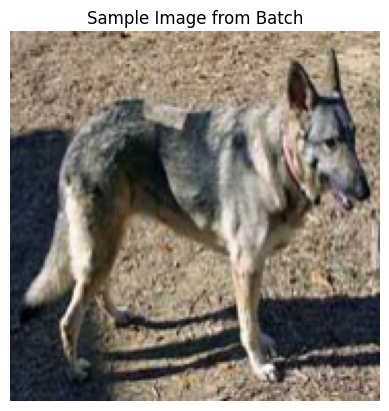

Shape of the image: (180, 180, 3)


In [7]:
# your code here

import matplotlib.pyplot as plt

# Take one image and one label from the sample_batch
one_image = sample_batch[0][0].numpy().astype("uint8")

# Display the image
plt.imshow(one_image)
plt.axis("off")
plt.title("Sample Image from Batch")
plt.show()

# Print the shape of the image
print("Shape of the image:", one_image.shape)


## Part A: Transferring `Xception` and Adding a Binary Classifier in a Single Architecture

### Instantiating and freezing the VGG16 convolutional base

In [8]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False) ## this means we only get the convolutional part without the densely connected top


conv_base.trainable = False ## This freezes the wieghts on the convolutional part

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [9]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

### ConvNet + Densely connected network

**TODO: Pass the preprocessed input from `conv_base and a binary classifier**

- binary classifier architecture:
  - one hideen layer with 256 unit and proper activation function
  - one drop out layer
  - output layer with 1 unit and proper activation function for binary classification. (1: Dog, 0: Cat)

In [10]:
#Solution
from tensorflow.keras import layers, models

classifier = models.Sequential([
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])


inputs = keras.Input(shape=(180, 180, 3))
processed = keras.applications.vgg16.preprocess_input(inputs)
features = conv_base(processed) # Convolutional base
flat = layers.Flatten()(features)
outputs = classifier(flat)

model_transfer = keras.Model(inputs, outputs)
intermediate_model = keras.Model(inputs, features)

In [11]:
model_transfer.summary() #look at the param # where the weights are forzen

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 180, 180)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 180, 180)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 180, 180)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 180, 180, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 180, 180, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 5, 5, 512)      │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 12800)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 1)              │      3,277,313 │ flatten[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 17,992,001 (68.63 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
intermediate_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 180, 180)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 180, 180)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 180, 180)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 180, 180, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 180, 180, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 5, 5, 512)      │     14,714,688 │ add[0][0]              │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

### Compile and train

In [13]:
model_transfer.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [14]:
history = model_transfer.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    )

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 400ms/step - accuracy: 0.8591 - loss: 19.1118 - val_accuracy: 0.9650 - val_loss: 0.6215
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 221ms/step - accuracy: 0.9688 - loss: 0.6277 - val_accuracy: 0.9710 - val_loss: 0.6769
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 215ms/step - accuracy: 0.9815 - loss: 0.4069 - val_accuracy: 0.9680 - val_loss: 0.8248
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - accuracy: 0.9932 - loss: 0.1063 - val_accuracy: 0.9770 - val_loss: 0.6423
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.9955 - loss: 0.0633 - val_accuracy: 0.9790 - val_loss: 0.6053
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - accuracy: 0.9941 - loss: 0.0664 - val_accuracy: 0.9700 - val_loss: 1.1232
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 229ms/step - accuracy: 0.9960 - loss: 0.0793 - val_accuracy: 0.9650 - val_loss: 1.1969
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - accuracy: 0.9946 - loss: 0.0455 - val_acc

### Plotting

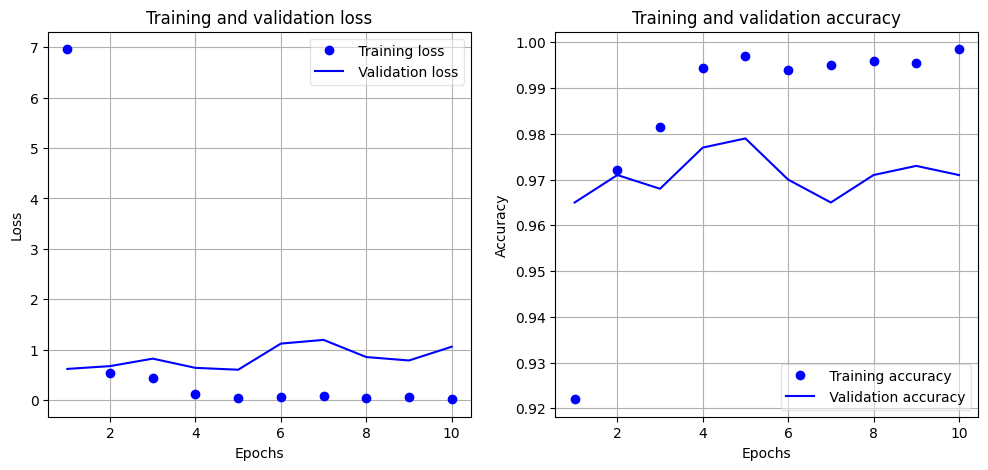

In [15]:
plot_history(history)

### Visualization of layers

**Printing the layer names of a deep learning model**

In [16]:
sample_image = sample_batch[:1]  # Shape should be (1, 180, 180, 3)
print(sample_image.shape)
print(sample_image.dtype)


AttributeError: 'tuple' object has no attribute 'shape'

In [17]:
intermediate_layer = intermediate_model.predict(sample_image) # this is the output of the convolutional base
intermediate_layer.shape

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_19
Received: inputs=('Tensor(shape=(32, 180, 180, 3))',)
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


(32, 5, 5, 512)

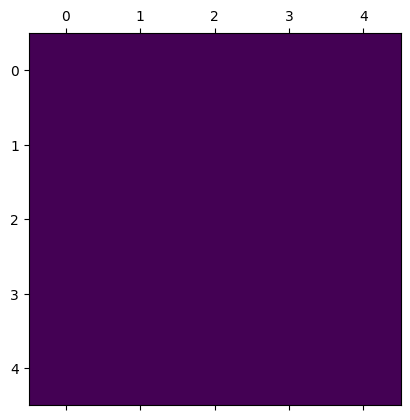

In [18]:
import matplotlib.pyplot as plt

plt.matshow(intermediate_layer[0, :, :, 3], cmap='viridis')
plt.show()

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_feature_maps(intermediate_layer, images_per_row=32):
    n_features = intermediate_layer.shape[-1]
    size = intermediate_layer.shape[1]
    n_cols = n_features // images_per_row

    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = intermediate_layer[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size: (col + 1) * size, row * size: (row + 1) * size] = channel_image

    plt.figure(figsize=(display_grid.shape[1] / size, display_grid.shape[0] / size))
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()

<ipython-input-19-44144891689d>:15: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
<ipython-input-19-44144891689d>:18: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


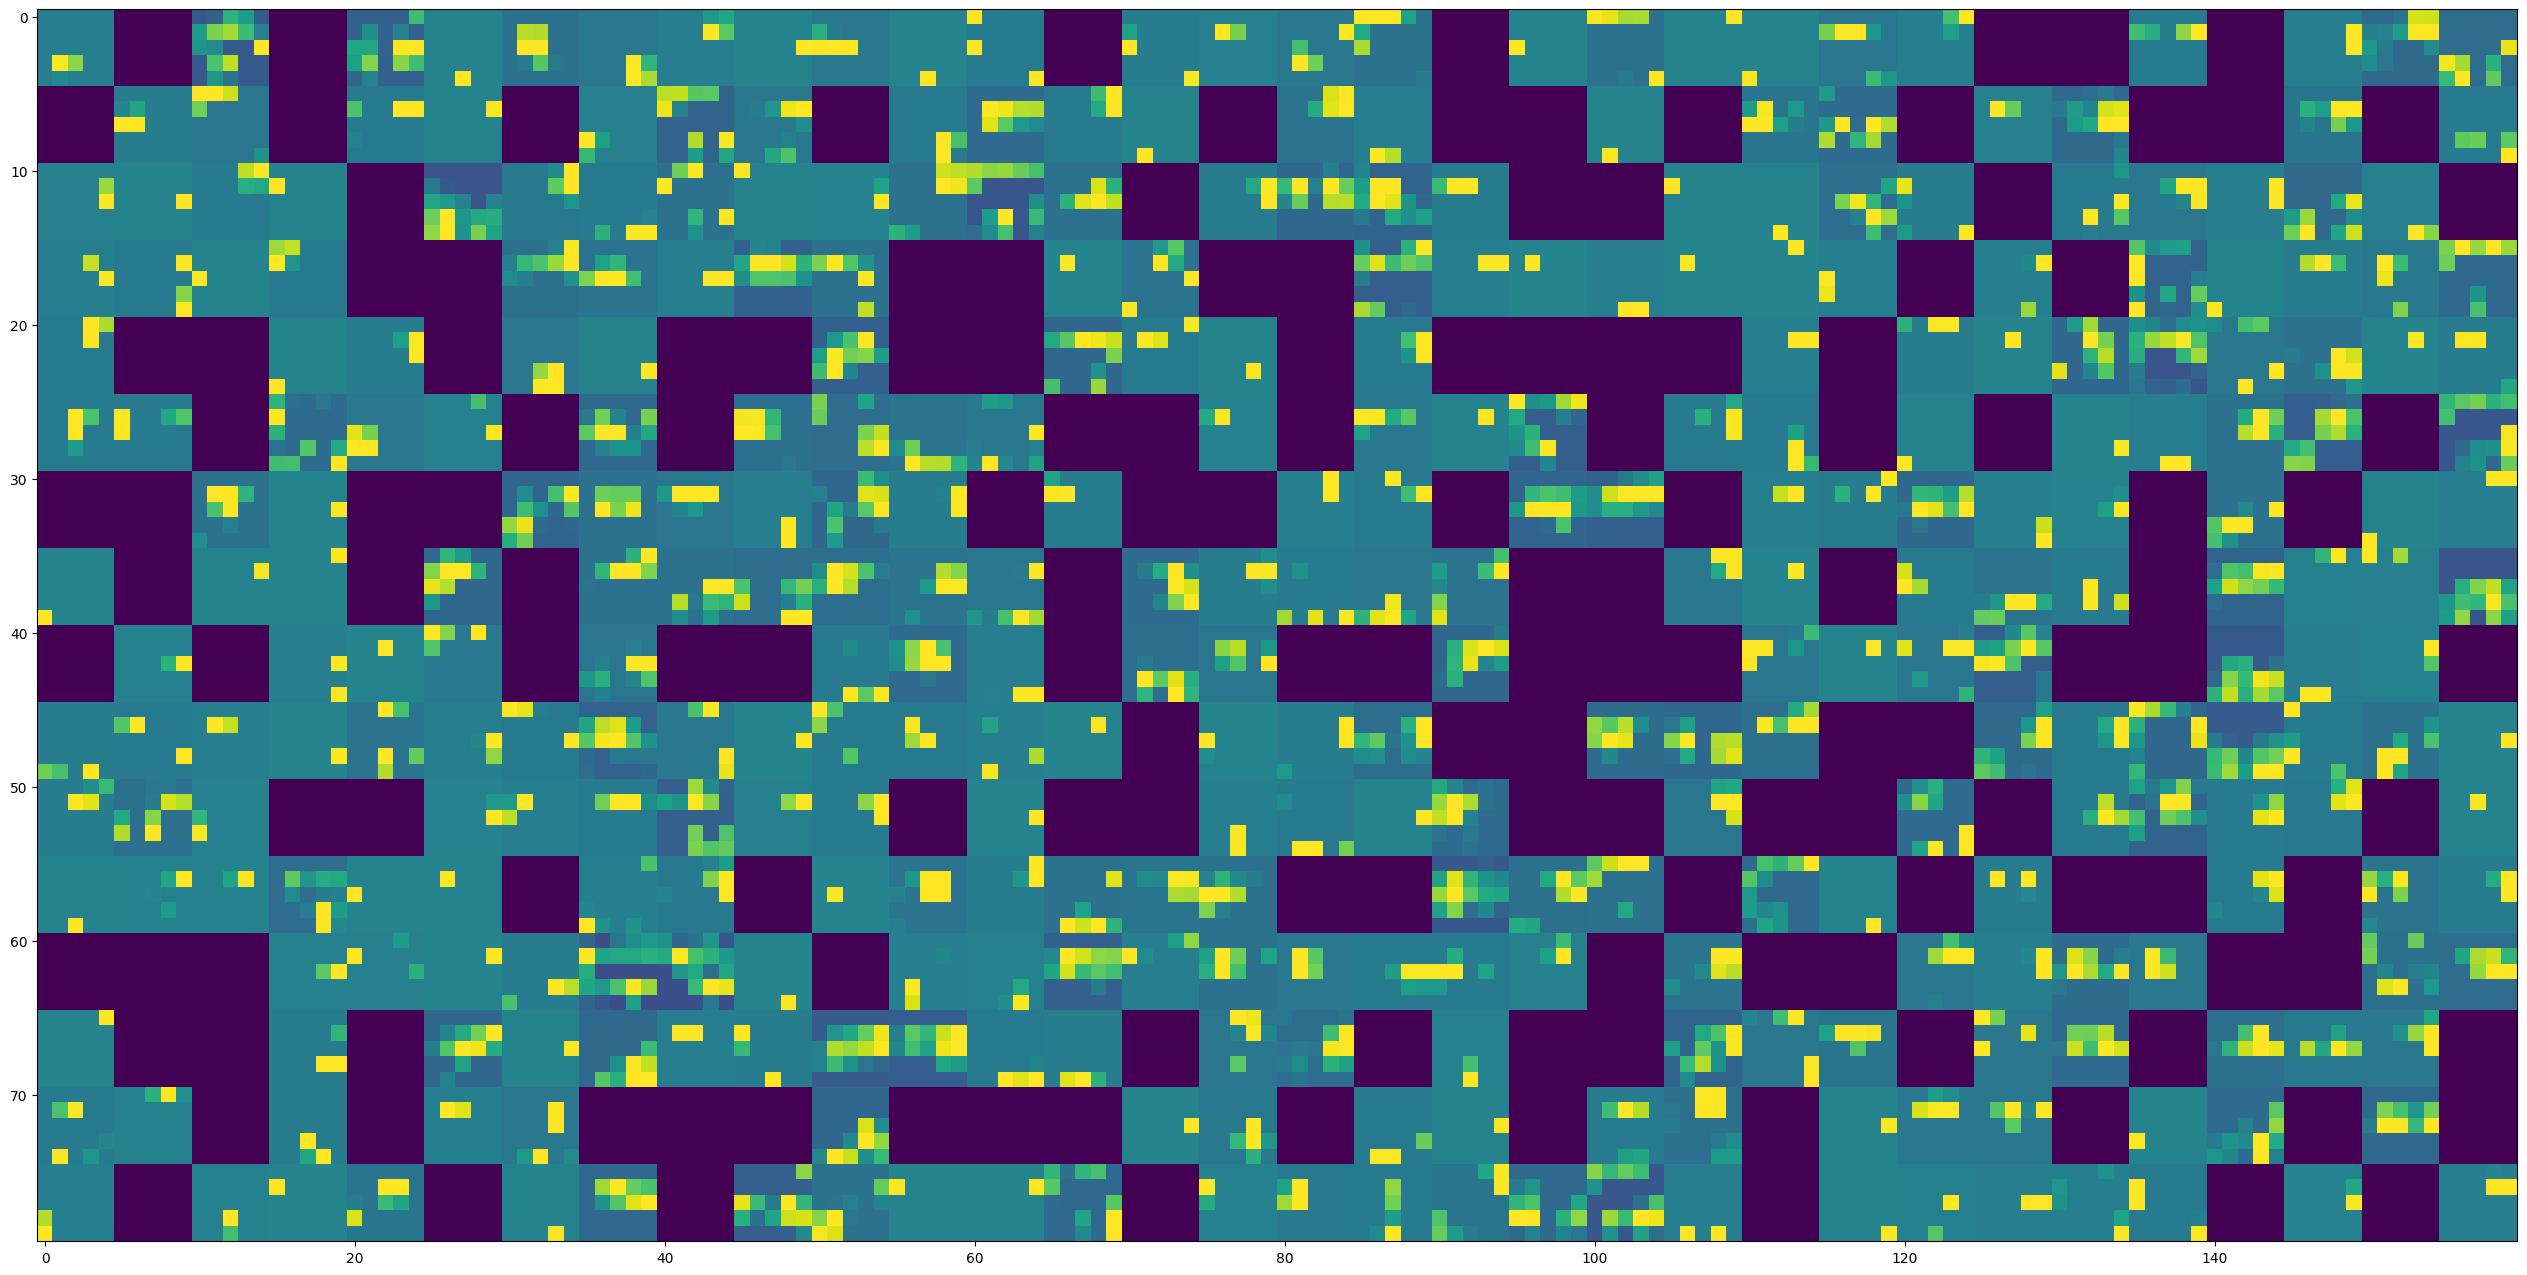

In [20]:
visualize_feature_maps(intermediate_layer)

## Part B: Fine-tuning the Xception model

In [21]:
#import vgg16 without the top
#you code here
from tensorflow.keras.applications import Xception

# Load the Xception model without the top (fully connected) layers
# and with weights pre-trained on ImageNet
conv_base = Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)



83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


### Unfreezing the last 2 blocks (Important Part!)

In [22]:
conv_base.trainable = True

for layer in conv_base.layers[:-2]:
    layer.trainable = False

### Fine-tuning the vgg16 model while training the classifier

**define the models: full model with classifier and intermediate model with conv_base**

In [23]:

# your code here

from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers

# Load VGG16 convolutional base
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(180, 180, 3))

# Freeze all layers in conv_base to prevent updating during initial training
conv_base.trainable = False

# Create the full model
full_model = models.Sequential([
    conv_base,  # Pretrained base
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification: cats vs dogs
])

# Compile the model
full_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)


**Compile and train the model**

### Plotting

**Plot your training and validation accuracy and loss**

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 343ms/step - accuracy: 0.8148 - loss: 3.7036 - val_accuracy: 0.9340 - val_loss: 0.7798
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step - accuracy: 0.9487 - loss: 0.6908 - val_accuracy: 0.9350 - val_loss: 0.7674
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.9689 - loss: 0.3116 - val_accuracy: 0.9450 - val_loss: 0.6636
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - accuracy: 0.9799 - loss: 0.1598 - val_accuracy: 0.9450 - val_loss: 0.6115
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 216ms/step - accuracy: 0.9865 - loss: 0.0934 - val_accuracy: 0.9490 - val_loss: 0.7230
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 225ms/step - accuracy: 0.9880 - loss: 0.0777 - val_accuracy: 0.9470 - val_loss: 0.6999
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - accuracy: 0.9888 - loss: 0.0746 - val_accuracy: 0.9470 - val_loss: 0.6829
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step - accuracy: 0.9960 - loss: 0.0201 - val_accu

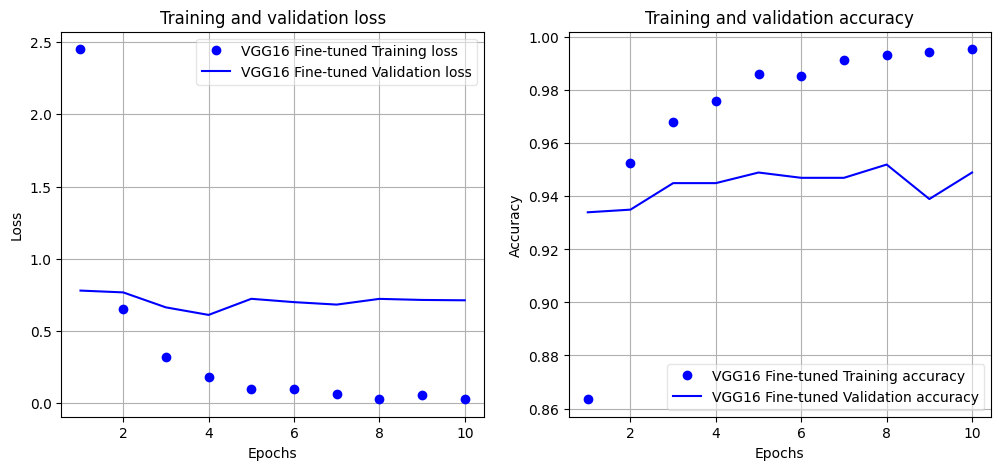

In [24]:
# your code here

# Train the model
history = full_model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset
)

# Plot the training history
plot_history(history, color='blue', prefix="VGG16 Fine-tuned")


### Visualization of layers

**Visulalize the feature maps of the last convolutional layer of the VGG16 model**

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


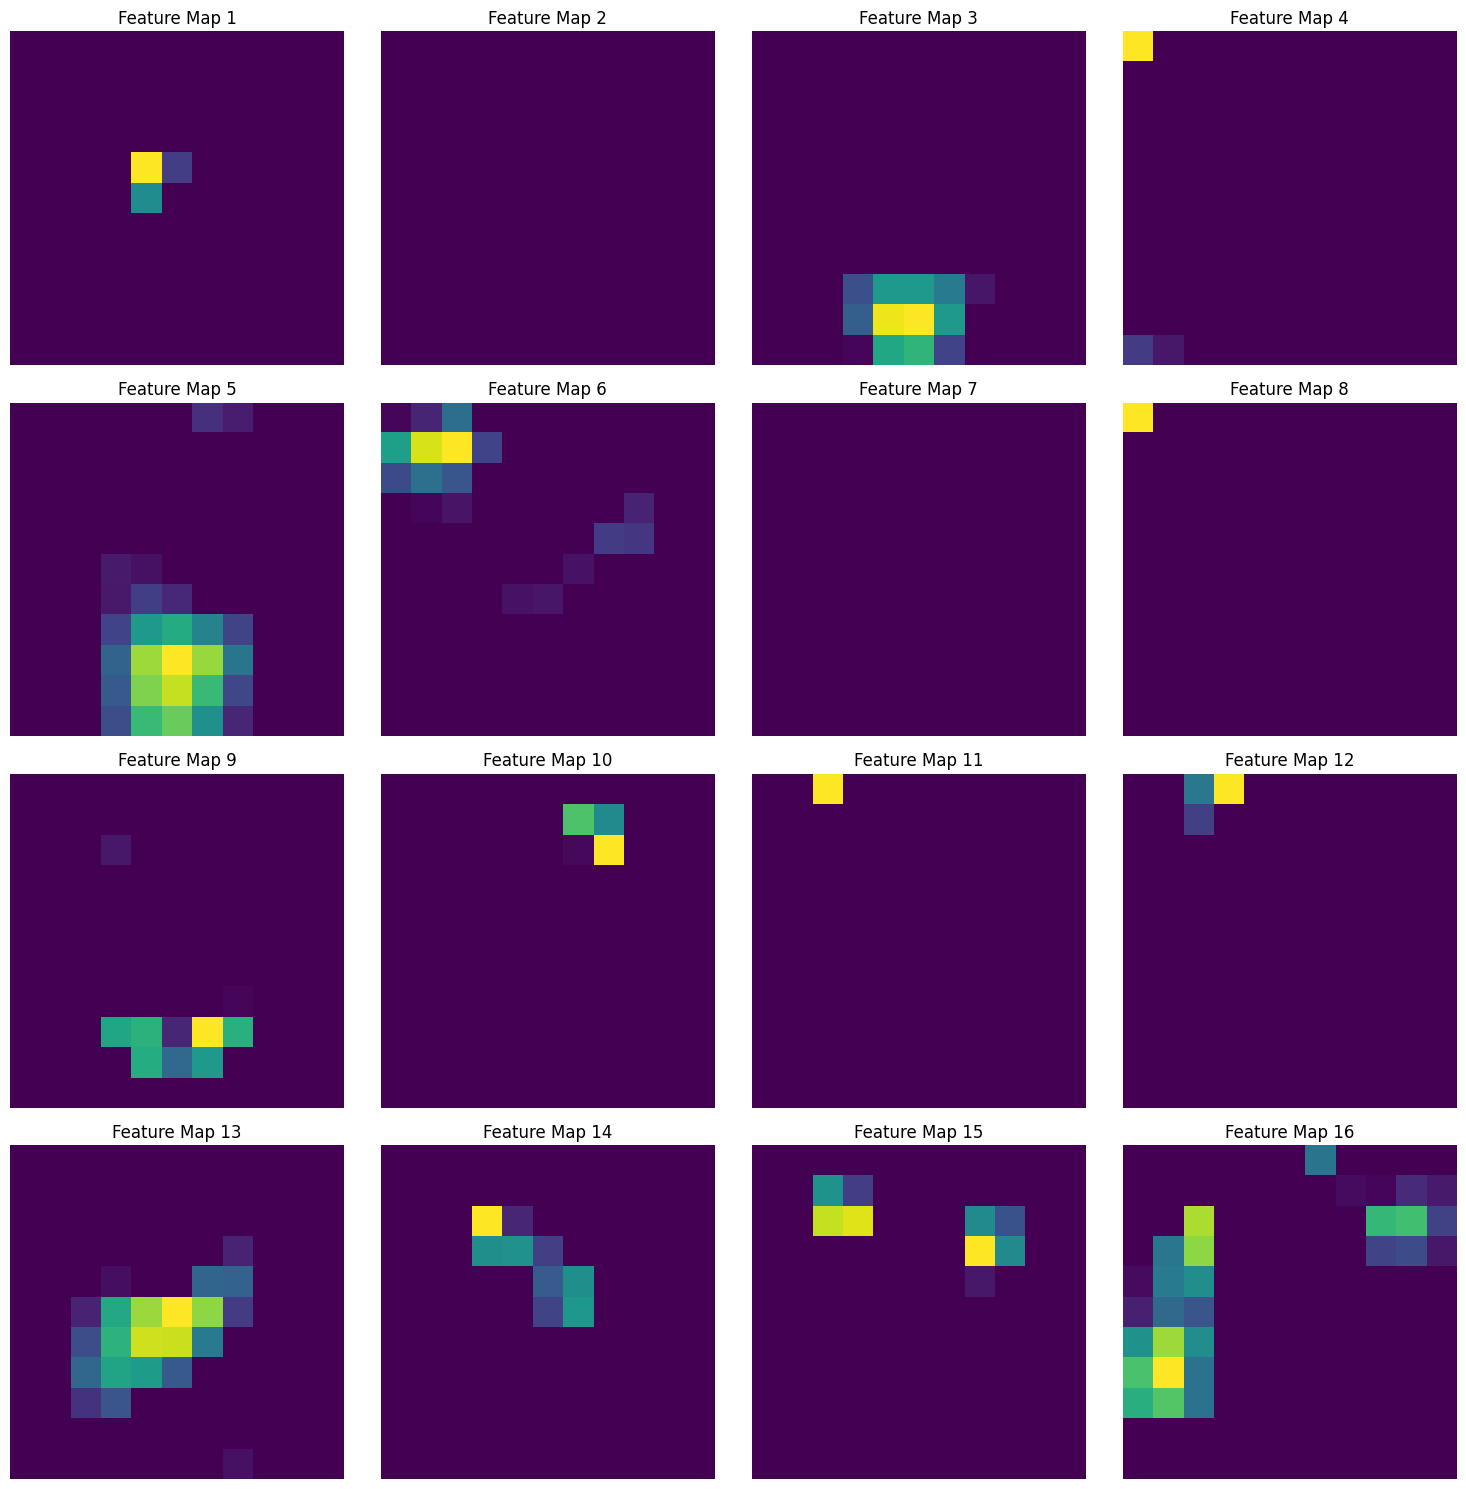

In [26]:
# your code here

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Create a model that outputs the last conv layer
layer_outputs_model = Model(inputs=conv_base.input, outputs=conv_base.get_layer("block5_conv3").output)

# Pick one image from the dataset and preprocess it
for images, labels in train_dataset.take(1):
    img = images[0].numpy().astype("uint8")
    break

# Expand dimensions and preprocess
img_batch = np.expand_dims(img, axis=0)
img_batch = tf.keras.applications.vgg16.preprocess_input(img_batch)

# Get the feature maps
feature_maps = layer_outputs_model.predict(img_batch)

# Plot the first 16 feature maps
plt.figure(figsize=(15, 15))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
    plt.axis("off")
    plt.title(f"Feature Map {i+1}")
plt.tight_layout()
plt.show()
